***

<p style="font-family:verdana;color:#29285D;font-size:300%;text-align:center"><b>🛒 CUSTOMER SEGMENTATION 🛒<br> WITH DEPLOYMENT</b></p> 
<p style="font-family:verdana;text-align:center">***************</p>
<p style="font-family:verdana;text-align:center">In this notebook i will be using K-Means clustering on given dataset to form the clusters. Then analyse the clusters for insights and do customer profiling. Then i will create a model using GradientBoosting Regressor to predict the cluster for new customer. I will creat a pipeline of all the code and deploy it using Flask. </p>
<p style="font-family:verdana;text-align:right;color:#03a564"><i>--Marcello Roy</i></p>
<p style="font-family:verdana;color:#29285D;font-size:150%;text-align:center">Don't Forget To Upvote If You Like The Notebook</p>

***

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> IMPORTING LIBRARIES & DATASET </p> 

### **Lets import the required libraries...**

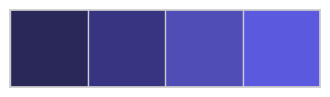

In [1]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations
pd.set_option('display.max_columns', None) # code to display all columns

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import date, datetime # for manupulating time and date columns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler # For handling categorical column and scaling numeric columns

# Libraries for clustering and evaluation
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

# set the color palette
palette = sns.color_palette(["#292859",'#373482','#504DB6','#5B59DD'])
sns.palplot(palette) # print color palette

### **Its time to load our data to `df` variable...**  
**Note:** The csv file is tab seperated, so i'll need to set `sep` parameter to `'\t'`

In [2]:
df = pd.read_csv('./marketing_campaign.csv', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: './marketing_campaign.csv'

***

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">INITIAL ANALYSIS</p> 

### **Understand The Data** 🧠
I always ask these following quetions to undertand the data
### 1.How big is data?

In [ ]:
df.shape

### 2.How does the data look like?

In [ ]:
df.sample(5) # sample selects random rows from your data 

### 3.What is the data type of cols?

In [ ]:
df.info()

### 4.Are there any missing values?

In [ ]:
df.isnull().sum()

### 5.How does the data look mathematically?

In [ ]:
df.describe()

### 6.Are there duplicate values?

In [ ]:
df.duplicated().sum()

<div style="color:white;
           display:fill;
           background-color:#29285D;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Data contains 2240 rows and 29 columns <br>
           2. It has 1 float, 3 object and 25 int columns <br>
           3. Datetime columns have int datatype, need to fix that <br>
           4. Many categorical columns are alredy in int format, like AcceptedCmp1, Response <br>
           5. There are 24 missing values in Income column <br>
           6. There are no duplicate values within data
        </p>
    </div>

***

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">DATA CLEANING & FEATURE CONSTRUCTION</p> 

### **Steps To Follow:**
*  First of all I am going to fix the column names
*  I will convert the datetime column into correct format
*  Then I'll take care of the missing values
*  Examin the unique values within categorical columns
*  Check the timeline of the data since we have datetime columns given

In [ ]:
df.rename(columns = {'MntGoldProds':'MntGoldProducts'}, inplace = True)

In [ ]:
# converting columns to DateTime format
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format ='%Y')
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format ='%Y')

In [ ]:
# Check the skewness before imputation of numeric cols
df['Income'].skew()

<div class="alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed.
If the skewness is less than -1 or greater than 1, the data are highly skewed.
</div>

In [ ]:
# Replacing null values with median cause the data is skewed which means there are outliers in the data
df['Income'].fillna(df['Income'].median(), inplace = True)

In [ ]:
# check the unique values
df['Education'].value_counts()

In [ ]:
# check the unique values
df['Marital_Status'].value_counts()

In [ ]:
# Convert Dt_Customer to datetime with error handling
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Drop rows with NaT (Not a Time)
df = df.dropna(subset=['Dt_Customer'])

# Extract the year and find min and max
min_year = df["Dt_Customer"].dt.year.min()
max_year = df["Dt_Customer"].dt.year.max()

min_year, max_year


### **Steps To Follow:**
*  Create `Age`,`Years_Customer` and `Days_Customer` columns by substracting last date of `Dt_Customer` from `Year_Birth` and `Dt_Customer`
*  Create `TotalMntSpent`,`TotalNumPurchases` and `TotalAccCmp` by adding the relative columns
*  Create `Year_Joined`,`Month_Joined` and `Day_Joined` columns through `dt_Customer`
*  Create `Age_Group` column by dividing `Age` column into different groups
*  Create `Children` column by adding `Kidhome` and `Teenhome` columns
* Create `Partner` and `Education_Level` for simplifying `Marital_Status` and `Education` columns
* Drop the redundant columns

In [ ]:
# Creating Age and Years_Customer ( Amount of years a personn has been customer) columns.
df['Age'] = (df["Dt_Customer"].dt.year.max()) - (df['Year_Birth'].dt.year)
df['Years_Customer'] = (df["Dt_Customer"].dt.year.max()) - (df['Dt_Customer'].dt.year)
df['Days_Customer'] = (df["Dt_Customer"].max()) - (df['Dt_Customer'])

# Total amount spent on products
df['TotalMntSpent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProducts']

# Total number of purchases made
df['TotalNumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

# Total number of accepted campaigns
df['Total_Acc_Cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

# adding columns about the day, month and year cutomer joined
df['Year_Joined'] = df['Dt_Customer'].dt.year
df['Month_Joined'] = df['Dt_Customer'].dt.strftime("%B")
df['Day_Joined'] = df['Dt_Customer'].dt.day_name()

# dividing age into groups
df['Age_Group'] = pd.cut(x = df['Age'], bins = [17, 24, 44, 64, 150],
                         labels = ['Young adult','Adult','Middel Aged','Senior Citizen'])
# Total children living in the household
df["Children"] = df["Kidhome"] +  df["Teenhome"]

#Deriving living situation by marital status
df["Partner"]=df["Marital_Status"].replace({"Married":"Yes", "Together":"Yes", "Absurd":"No", "Widow":"No", "YOLO":"No", "Divorced":"No", "Single":"No","Alone":"No"})

#Segmenting education levels in three groups
df["Education_Level"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [ ]:
# Dropping useless columns
df.drop(['ID','Z_CostContact','Z_Revenue','Year_Birth','Dt_Customer'], axis=1, inplace=True)

In [ ]:
# Converting Days_Joined to int format
df['Days_Customer'] = df['Days_Customer'].dt.days.astype('int16')

In [ ]:
print(df.shape)
df.sample(5)

<div class="alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; The above dataset is really good to perform EDA. I can extract really good insights from all these columns. However i won't be using all these columns to form clusters. Lots of the data we have like Amount spents on different products, number of purchases etc. This data won't be available for new customers. So i will be training model using those columns only wich will be available for new customers so the model can predict the cluster. I hope you Understood it.
</div>

I have seperate notebook for eda --> [here](https://www.kaggle.com/code/rohitshirudkar/customer-personality-data-analysis-eda?scriptVersionId=99776600&cellId=32) <br>
I also have performed clustering on all columns using PCA & K-Means --> [here](https://www.kaggle.com/code/rohitshirudkar/complete-customer-segmentation-pca-k-means)

In [ ]:
df1 = df.copy() # make a copy
df1.drop(['Education','Marital_Status','Years_Customer','Year_Joined','Month_Joined','Day_Joined'], axis=1, inplace=True)

#### Let's use capping technique to treat outliers

Capping:
Instead of trimming or removing the values from the dataset, we convert the outliers and bring them in the limit or range of our data. Here we will convert all the outliers values to value of upper whisker and lower whisker.

In [ ]:
num_col = df1.select_dtypes(include = np.number).columns

In [ ]:
for col in num_col:
    q1 = df1[col].quantile(0.25)
    q3 = df1[col].quantile(0.75)
    iqr = q3-q1
    ll = q1-(1.5*iqr)
    ul = q3+(1.5*iqr)
    for ind in df1[col].index:
        if df1.loc[ind,col]>ul:
            df1.loc[ind,col]=ul
        elif df1.loc[ind,col]<ll:
            df1.loc[ind,col]=ll
        else:
            pass
print("Outliers have been taken care of")

***

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">FEATURE TRANSFORMATION</p> 

As I already explained above, I will use subset of data to form clusters

In [ ]:
# selecting the cols to use
subset = df1[['Income','Kidhome','Teenhome','Age','Partner','Education_Level']]
print('This is the data we will use for clustering:')
subset.head()

In [ ]:
# examin the min, max and mean of your columns
subset.describe()

### **Make the pipelines**

<div class="alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; Pipeline: A machine learning pipeline is a way to codify and automate the workflow it takes to produce a machine learning model. Machine learning pipelines consist of multiple sequential steps that do everything from data extraction and preprocessing to model training and deployment.
</div>

Always try to build pipelines whenever you are going to deploy the model

In [ ]:
# Importing essential libraries for bulding pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
# I am not scaling the kidhome, teenhome cols, cause thire min, max lies between 0 & 2
num_cols = ['Income','Age']
numeric_pipeline = make_pipeline(StandardScaler())

In [ ]:
ord_cols = ['Education_Level']
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[['Undergraduate','Graduate','Postgraduate']]))

In [ ]:
nom_cols = ['Partner']
nominal_pipeline = make_pipeline(OneHotEncoder())

In [ ]:
# stack your pipelines in column transformer
transformer = ColumnTransformer(transformers=[('num',numeric_pipeline,num_cols),
                                           ('ordinal', ordinal_pipeline,ord_cols),
                                              ('nominal' ,nominal_pipeline,nom_cols)
                                             ])

In [ ]:
transformer

In [ ]:
# Now lets fit and transform the data
transformed = transformer.fit_transform(subset)
print('Data has been Transformed')

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">K-MEANS CLUSTERING & CLUSTER's ANALYSIS </p> 

<div class="alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; The KElbowVisualizer implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for K.
</div>



In [ ]:
plt.figure(figsize=(12, 8))
elbow_graph = KElbowVisualizer(KMeans(random_state=43), k=10)
elbow_graph.fit(transformed)
elbow_graph.show()

From above it is clear that k=4

In [ ]:
# using k-means to form clusters
kmeans = KMeans(n_clusters=4, random_state=42)
subset['Clusters'] = kmeans.fit_predict(transformed) #fit the data and adding back clusters to the data in clusters column

In [ ]:
subset.head()

In [ ]:
# count plot to see number of customers in each cluster
plt.figure(figsize=(12, 8))
sns.countplot(x='Clusters', data=subset, palette=palette)
plt.title('Customer Distribution Within Clusters')
plt.show()

<div style="color:white;
           display:fill;
           background-color:#29285D;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Cluster 2 has highest number of customers <br>
           2. Cluster 3 has least number of customers <br>
        </p>
    </div>

### Lets find out what number of customers in each cluster have how many Kids or Teens in household, how many of them have partner and their education level

In [ ]:
# create list of categories
count_cols= ['Kidhome','Teenhome','Partner','Education_Level']

_, ax1 = plt.subplots(2,2, figsize=(25,22))

for i, col in enumerate(count_cols):
    sns.countplot(x='Clusters', data=subset, ax=ax1[i//2, i%2],hue=col,palette=palette)
    
plt.show()

<div style="color:white;
           display:fill;
           background-color:#29285D;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>

    
**Kidhome:**
* Cluster 0 mostly has customers with 1 kid in household 
* Cluster 1 has customers with no kids in household
* Cluster 2 also has large number of customers with no kids in household
* Cluster 3 has customers with 0 and 1 kids in household
    
**Teenhome:**
* Cluster 0 consist of customers with no teen in household & few of them have 1 Teen in household
* Same goes for the cluster 1 & 3
* Cluster 2 has customers with 1 Teen in household

**Partner:**
* All the customers in cluster 0 have partner
* All The customers in cluster 3 have no partner
* Cluster 1 & 2 has customers with and without partner, but most of them have partner

**Education_Level:**
* All clusters have customers with graduate, postgraduate and undergraduate background
* All clusters have less number of customers with undergraduate background
* Cluter 2 has highest number of postgraduates and graduates 
       
    </div>

In [ ]:
# Find out the customers which have kids in different clusters
plt.figure(figsize=(12, 8))
sns.barplot(x=subset["Clusters"], y=subset["Kidhome"],palette=palette)
plt.title("Kids In Household vs Clusters", size=15)
plt.show()

**Observation:**
* Cluster 0 and 3 has the maximum number of customers with kids in household
* Cluster 1 and 2 has the least number of customers with kids in household

In [ ]:
# Find out the customers which have kids in different clusters
plt.figure(figsize=(12, 8))
sns.barplot(x=subset["Clusters"], y=subset["Teenhome"],palette=palette)
plt.title("Teens In Household vs Clusters", size=15)
plt.show()

<div style="color:white;
           display:fill;
           background-color:#29285D;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Cluster 2 has maximum number of customers having Teens in household <br>
           2. Remaining Clusters also have customers with Teens in household but they are less as compared to cluster 2 <br>
        </p>
    </div>

In [ ]:
# Lets findout income of customers with in clusters
plt.figure(figsize=(12, 8))
sns.barplot(x=subset["Clusters"], y=subset["Income"],palette=palette)
plt.title("Income vs Clusters", size=15)
plt.show()

<div style="color:white;
           display:fill;
           background-color:#29285D;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Cluster 1 has high Income followed by cluster 2. Which is little strange cause cluster 2 has highest number of customers and most number of post graduates & graduates as compared to cluster 1<br>
           2. Cluster 0 and 3 has least income<br>
        </p>
    </div>

### Following graphs shows what are the contributing factors in income

In [ ]:
catcols= ['Kidhome','Teenhome','Partner','Education_Level']

_, ax1 = plt.subplots(2,2, figsize=(25,22))

for i, col in enumerate(catcols):
    sns.barplot(x='Clusters', y='Income', data=subset, ax=ax1[i//2, i%2],hue=col,palette=palette)
    
plt.show()

<div style="color:white;
           display:fill;
           background-color:#29285D;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. Very interesting thing i can see from first 2 plots is, We saw before the number of  customers with 2 kids or teens is very very less still their income is similar to the customers which have no kids or teens or have 1 kid & teen. So I conclude that the customers with more than 1 kid or teen in houehold has high household income 1<br>
           2. From last 2 plots i think education_level and partner has nothing to do with income. Infact undergraduates are earniing equal or more than graduates and postgraduates within each cluster.<br>
        </p>
    </div>

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">CUSTOMER PROFILING</p> 

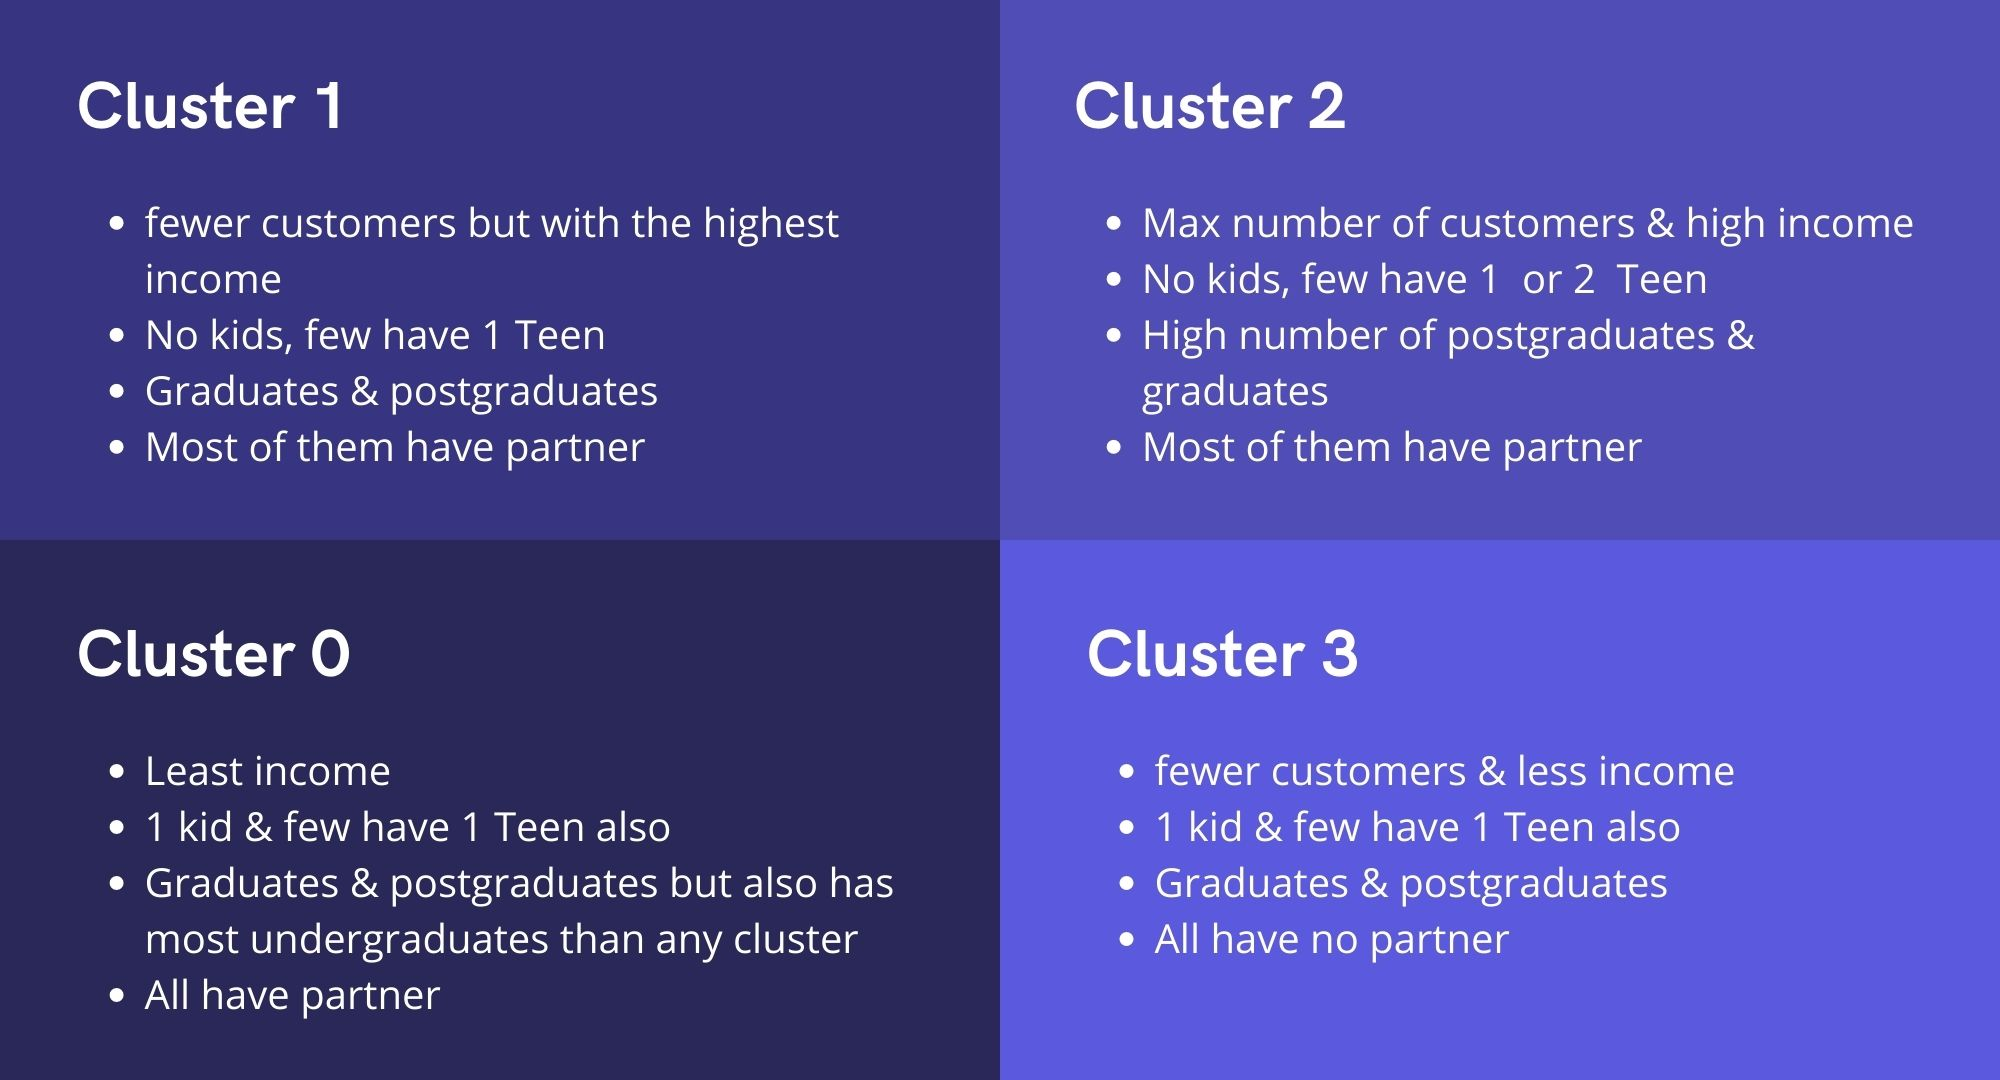

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">MODEL BUILDING</p> 

### Now lets build a multi classification model that will predict the cluster for given input of perticular customer
### **Steps To Follow:**
* Import required libraries
* Separate features and target column (Clusters)
* Create train and test data by spliting
* Just add gradient boosting classifier to existing transformer pipeline
* Fit data to the new pipeline

In [ ]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# separate features and target column
x = subset.drop('Clusters', axis=1)
y = subset['Clusters']

In [ ]:
# create train and test data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [ ]:
# adding GradientBoostingClassifier to transformer pipeline
final_pipeline = make_pipeline(transformer, GradientBoostingClassifier())

In [ ]:
# fit the data to new pipeline & model
final_pipeline.fit(x_train, y_train)

### Above is the diagram with all the steps in our pipeline

In [ ]:
# check the accuracy of our model
final_pipeline.score(x_test, y_test)

### You can export this pipeline with all the transformation and trained model

In [ ]:
import pickle

In [ ]:
filename = 'classifier.pkl' # create a variable with name you wanna give to the file
pickle.dump(final_pipeline, open(filename,'wb')) 

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">MODEL DEPLOYMENT</p> 

Customer_segmentation.py

In [ ]:
from flask import Flask, render_template, request
import pickle
import pandas as pd

# Load the model
classifier = pickle.load(open('classifier.pkl', 'rb'))

app = Flask(__name__)

# Customer segmentation function
def segment_customers(input_data):
    prediction = classifier.predict(
        pd.DataFrame([input_data], columns=['Income', 'Kidhome', 'Teenhome', 'Age', 'Partner', 'Education_Level']))
    return prediction[0]

# Route to render the form and handle prediction

# Define routes
@app.route('/')
def home():
    return render_template('predict.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Get form inputs
        income = float(request.form['income'])
        kidhome = int(request.form['num_kids'])
        teenhome = int(request.form['num_teens'])
        age = int(request.form['age'])
        partner = request.form['partner']
        education_level = request.form['education']

        # Convert education level to match the model's expected format
        if education_level == 'high_school':
            education_level = 'Undergraduate'
        elif education_level == 'bachelors':
            education_level = 'Graduate'
        elif education_level == 'phd':
            education_level = 'Postgraduate'

        # Prepare input data for prediction
        input_data = {
            'Income': income,
            'Kidhome': kidhome,
            'Teenhome': teenhome,
            'Age': age,
            'Partner': partner,
            'Education_Level': education_level
        }

        # Perform segmentation and get prediction
        prediction = segment_customers(input_data)

        # Map numeric prediction to readable label
        cluster_map = {
            0: 'Cluster 0',
            1: 'Cluster 1',
            2: 'Cluster 2',
            3: 'Cluster 3'
        }

        predicted_cluster = cluster_map[prediction]

        # Render predict.html with prediction result
        return render_template('predict.html', prediction_result=predicted_cluster)

    # Render the initial form (GET request)
    return render_template('predict.html')

if __name__ == '__main__':
    app.run(debug=True)

# <p style="background-color:#29285D;font-family:verdana;color:white;font-size:100%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px">MODEL.PY</p> 

In [ ]:
import numpy as np  # Numerical Python library for linear algebra and computations
import pandas as pd  # Python library for data analysis and data frame

# Set option to display all columns
pd.set_option('display.max_columns', None)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure inline plotting in Jupyter notebooks (remove if not using a notebook)
# %matplotlib inline

# Libraries for handling categorical column and scaling numeric columns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Libraries for clustering and evaluation
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")  # To prevent kernel from showing any warning

# Set the color palette
palette = sns.color_palette(["#292859", '#373482', '#504DB6', '#5B59DD'])
sns.palplot(palette)  # Print color palette

# Example dataset loading and preprocessing
# Load dataset
df = pd.read_csv('./marketing_campaign.csv', sep='\t')

#Data Cleaning
df.rename(columns = {'MntGoldProds':'MntGoldProducts'}, inplace = True)
# converting columns to DateTime format
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format ='%Y')
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format ='%Y')

df['Income'].skew()
df['Income'].fillna(df['Income'].median(), inplace = True)

# Convert Dt_Customer to datetime with error handling
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Drop rows with NaT (Not a Time)
df = df.dropna(subset=['Dt_Customer'])

# Extract the year and find min and max
min_year = df["Dt_Customer"].dt.year.min()
max_year = df["Dt_Customer"].dt.year.max()

min_year, max_year

# Creating Age and Years_Customer ( Amount of years a personn has been customer) columns.
df['Age'] = (df["Dt_Customer"].dt.year.max()) - (df['Year_Birth'].dt.year)
df['Years_Customer'] = (df["Dt_Customer"].dt.year.max()) - (df['Dt_Customer'].dt.year)
df['Days_Customer'] = (df["Dt_Customer"].max()) - (df['Dt_Customer'])

# Total amount spent on products
df['TotalMntSpent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProducts']

# Total number of purchases made
df['TotalNumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

# Total number of accepted campaigns
df['Total_Acc_Cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

# adding columns about the day, month and year cutomer joined
df['Year_Joined'] = df['Dt_Customer'].dt.year
df['Month_Joined'] = df['Dt_Customer'].dt.strftime("%B")
df['Day_Joined'] = df['Dt_Customer'].dt.day_name()

# dividing age into groups
df['Age_Group'] = pd.cut(x = df['Age'], bins = [17, 24, 44, 64, 150],
                         labels = ['Young adult','Adult','Middel Aged','Senior Citizen'])
# Total children living in the household
df["Children"] = df["Kidhome"] +  df["Teenhome"]

#Deriving living situation by marital status
df["Partner"]=df["Marital_Status"].replace({"Married":"Yes", "Together":"Yes", "Absurd":"No", "Widow":"No", "YOLO":"No", "Divorced":"No", "Single":"No","Alone":"No"})

#Segmenting education levels in three groups
df["Education_Level"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

# Dropping useless columns
df.drop(['ID','Z_CostContact','Z_Revenue','Year_Birth','Dt_Customer'], axis=1, inplace=True)

# Converting Days_Joined to int format
df['Days_Customer'] = df['Days_Customer'].dt.days.astype('int16')

df1 = df.copy() # make a copy
df1.drop(['Education','Marital_Status','Years_Customer','Year_Joined','Month_Joined','Day_Joined'], axis=1, inplace=True)

num_col = df1.select_dtypes(include = np.number).columns

for col in num_col:
    q1 = df1[col].quantile(0.25)
    q3 = df1[col].quantile(0.75)
    iqr = q3-q1
    ll = q1-(1.5*iqr)
    ul = q3+(1.5*iqr)
    for ind in df1[col].index:
        if df1.loc[ind,col]>ul:
            df1.loc[ind,col]=ul
        elif df1.loc[ind,col]<ll:
            df1.loc[ind,col]=ll
        else:
            pass
print("Outliers have been taken care of")

# selecting the cols to use
subset = df1[['Income','Kidhome','Teenhome','Age','Partner','Education_Level']]
print('This is the data we will use for clustering:')
subset.head()

# Importing essential libraries for bulding pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# I am not scaling the kidhome, teenhome cols, cause thire min, max lies between 0 & 2
num_cols = ['Income','Age']
numeric_pipeline = make_pipeline(StandardScaler())

ord_cols = ['Education_Level']
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[['Undergraduate','Graduate','Postgraduate']]))

nom_cols = ['Partner']
nominal_pipeline = make_pipeline(OneHotEncoder())

# stack your pipelines in column transformer
transformer = ColumnTransformer(transformers=[('num',numeric_pipeline,num_cols),
                                           ('ordinal', ordinal_pipeline,ord_cols),
                                              ('nominal' ,nominal_pipeline,nom_cols)
                                             ])

transformer

# Now lets fit and transform the data
transformed = transformer.fit_transform(subset)
print('Data has been Transformed')

#K-MEANS CLUSTERING & CLUSTER's ANALYSIS

#📌 The KElbowVisualizer implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for K.

plt.figure(figsize=(12, 8))
elbow_graph = KElbowVisualizer(KMeans(random_state=43), k=10)
elbow_graph.fit(transformed)
elbow_graph.show()

# using k-means to form clusters
kmeans = KMeans(n_clusters=4, random_state=42)
subset['Clusters'] = kmeans.fit_predict(transformed) #fit the data and adding back clusters to the data in clusters column

# create list of categories
count_cols = ['Kidhome', 'Teenhome', 'Partner', 'Education_Level']

_, ax1 = plt.subplots(2, 2, figsize=(25, 22))

for i, col in enumerate(count_cols):
    sns.countplot(x='Clusters', data=subset, ax=ax1[i // 2, i % 2], hue=col, palette=palette)

plt.show()

# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# separate features and target column
x = subset.drop('Clusters', axis=1)
y = subset['Clusters']

# create train and test data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

# adding GradientBoostingClassifier to transformer pipeline
final_pipeline = make_pipeline(transformer, GradientBoostingClassifier())

# fit the data to new pipeline & model
final_pipeline.fit(x_train, y_train)

# check the accuracy of our model
final_pipeline.score(x_test, y_test)

import pickle
filename = 'classifier.pkl' # create a variable with name you wanna give to the file
pickle.dump(final_pipeline, open(filename,'wb'))



# SAMPLES

In [ ]:
subset